# 2D simulation with SPECFEM2D
By Andrea R. using utility functions written by Ridvan Orsvuran

In [1]:
import os
import shutil
import obspy
import numpy as np
import matplotlib.pyplot as plt
import FunctionsPlotBin
import sys
import IPython.display as dp

from scipy.interpolate import griddata
from PIL import Image

In [2]:
# Some utility functions (written by Ridvan Orsvuran)
def read_trace(filename):
    """Reads an ASCII file and returns a obspy Traces"""
    data = np.loadtxt(filename)
    # first column is time, second column is the data
    times = data[:, 0]
    disp = data[:, 1]
    # get station name from the filename
    net, sta, comp, *_ = filename.split("/")[-1].split(".")
    delta = times[1] - times[0]
    headers = {"station": sta, "network": net, "channel": comp, "delta": delta, "b": times[0]}
    return obspy.Trace(disp, headers)

def save_trace(tr, filename):
    """Writes out the traces as an ASCII file. Uses b value as the beginning."""
    data = np.zeros((len(tr.data), 2))
    data[:, 0] = tr.times()+tr.stats.b
    data[:, 1] = tr.data
    np.savetxt(filename, data)
       
def specfem_write_parameters(filename, parameters, output_file=None):
    """Write parameters to a specfem config file"""

    with open(filename) as f:
        pars = f.read()

    for varname, value in parameters.items():
        pat = re.compile(
            r"(^{varname}\s*=\s*)([^#$\s]+)".format(varname=varname),
            re.MULTILINE)
        pars = pat.sub(r"\g<1>{value}".format(value=value), pars)

    if output_file is None:
        output_file = filename

    with open(output_file, "w") as f:
        f.write(pars)     
        
def specfem2D_prep_save_forward(filename=None):
    if filename is None:
        filename = "./DATA/Par_file"
    params = {
        "SIMULATION_TYPE": 1,
        "SAVE_FORWARD": ".true."
    }
    specfem_write_parameters(filename, params)
    
def specfem2D_prep_adjoint(filename=None):
    if filename is None:
        filename = "./DATA/Par_file"
    params = {
        "SIMULATION_TYPE": 3,
        "SAVE_FORWARD": ".false."
    }
    specfem_write_parameters(filename, params)
      
def grid(x, y, z, resX=100, resY=100):
    """
    Converts 3 column data to matplotlib grid
    """
    # Can be found in ./utils/Visualization/plot_kernel.py
    from scipy.interpolate import griddata

    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)

    # mlab version
    #Z = griddata(x, y, z, xi, yi, interp='linear')
    # scipy version
    Z = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

### Set Specfem2D directory path

In [3]:
specfem2d_path = "/Users/andreacamilarianoescandon/packages"
EXAMPLE = os.path.join(os.getcwd(),"Examples", "DATA_Example03")
WORKDIR = os.path.join(os.getcwd(),"work")

# Incase we've run this docs page before, delete the working directory before remaking
if os.path.exists(WORKDIR):
    shutil.rmtree(WORKDIR)

os.mkdir(WORKDIR)

In [4]:
# Distribute the necessary file structure of the SPECFEM2D repository that we will download/reference
SPECFEM2D_ORIGINAL = os.path.join(specfem2d_path, "specfem2d") 
SPECFEM2D_BIN_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "bin")
SPECFEM2D_DATA_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "DATA")

# The SPECFEM2D working directory that we will create separate from the downloaded repo
SPECFEM2D_WORKDIR = os.path.join(WORKDIR, "ExampleLayeredModel")
SPECFEM2D_BIN = os.path.join(SPECFEM2D_WORKDIR, "bin")
SPECFEM2D_DATA = os.path.join(SPECFEM2D_WORKDIR, "DATA")
SPECFEM2D_OUTPUT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES")


### Run the mesher and the solver

In [5]:
# create the OUTPUT_FILES directory before running 
if os.path.exists(SPECFEM2D_WORKDIR):
    shutil.rmtree(SPECFEM2D_WORKDIR)
os.mkdir(SPECFEM2D_WORKDIR)
os.chdir(SPECFEM2D_WORKDIR)

# Copy the binary files incase we update the source code. These can also be symlinked.
shutil.copytree(SPECFEM2D_BIN_ORIGINAL, SPECFEM2D_BIN)

# Copy the DATA/ directory 
shutil.copytree(EXAMPLE, SPECFEM2D_DATA)

if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)
os.mkdir(SPECFEM2D_OUTPUT)

# run mesher and solver
!bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!bin/xspecfem2D > OUTPUT_FILES/solver_log.txt

!head -n 480 OUTPUT_FILES/solver_log.txt


 **********************************************
 **** Specfem 2-D Solver - serial version  ****
 **********************************************

 Running Git version of the code corresponding to 
 dating From 


 NDIM =            2

 NGLLX =            5
 NGLLZ =            5

 using single precision for the calculations

 smallest and largest possible floating-point numbers are:    1.17549435E-38   3.40282347E+38

 Reading the parameter file...

 Title of the simulation: Test of SPECFEM2D - layered model


   using existing STATIONS file: ./DATA/STATIONS
   file name is ./DATA/STATIONS
   found            1  receivers

 Parameter file successfully read 

 Reading in SOURCE file...

 Source           1
   Position xs, zs =    1000.0000000000000        2000.0000000000000     

   Source type (1=force, 2=moment tensor):            1
   Force source:
   Angle of the source (deg) =    0.0000000000000000     

   Time function type (1=Ricker, 2=First derivative, 3=Gaussian, 4=Dirac, 5=Hea

### 3. Plot synthetic seismogram

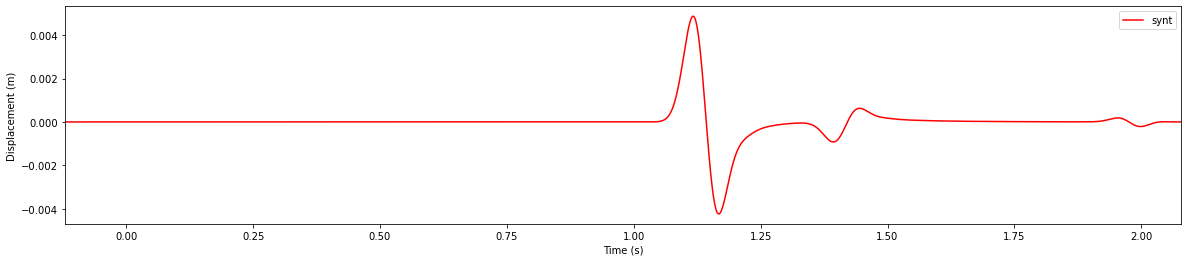

In [6]:
# Read synthetic seismogram
synt = read_trace(os.path.join(SPECFEM2D_OUTPUT,"AA.S0001.BXY.semd"))

# Process data
synt.detrend("simple")
synt.taper(0.05)
synt.filter("bandpass", freqmin=0.01, freqmax=20)

fig, ax = plt.subplots(figsize=(20, 4))
# Use the beginning time value from the file: tr.times()+tr.stats.b
ax.plot(synt.times()+synt.stats.b, synt.data, "r", label="synt")
ax.set_xlim(synt.stats.b, synt.times()[-1]+synt.stats.b)
ax.legend()
ax.set_xlabel("Time (s)");
ax.set_ylabel("Displacement (m)");

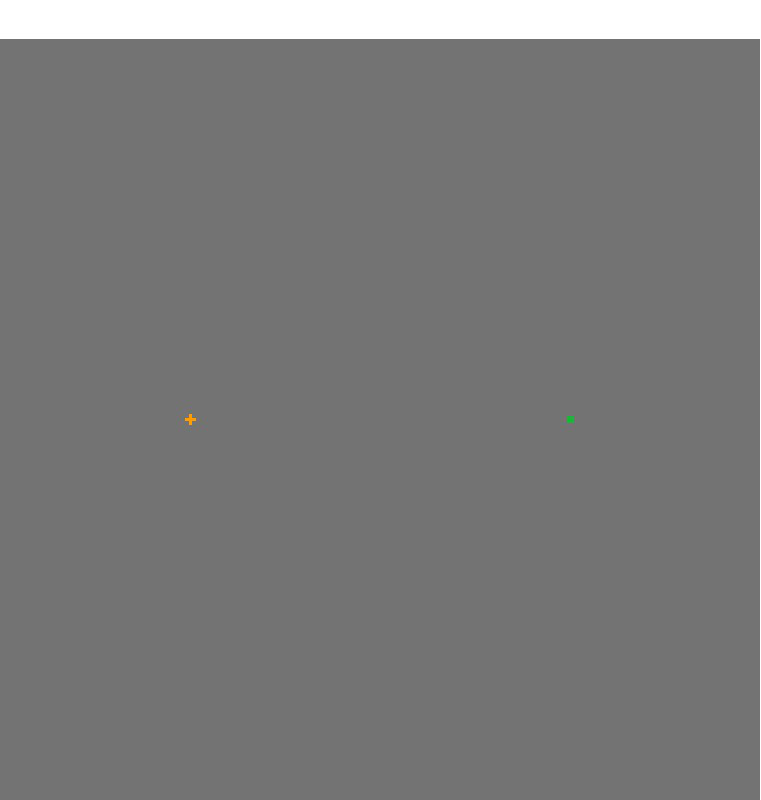

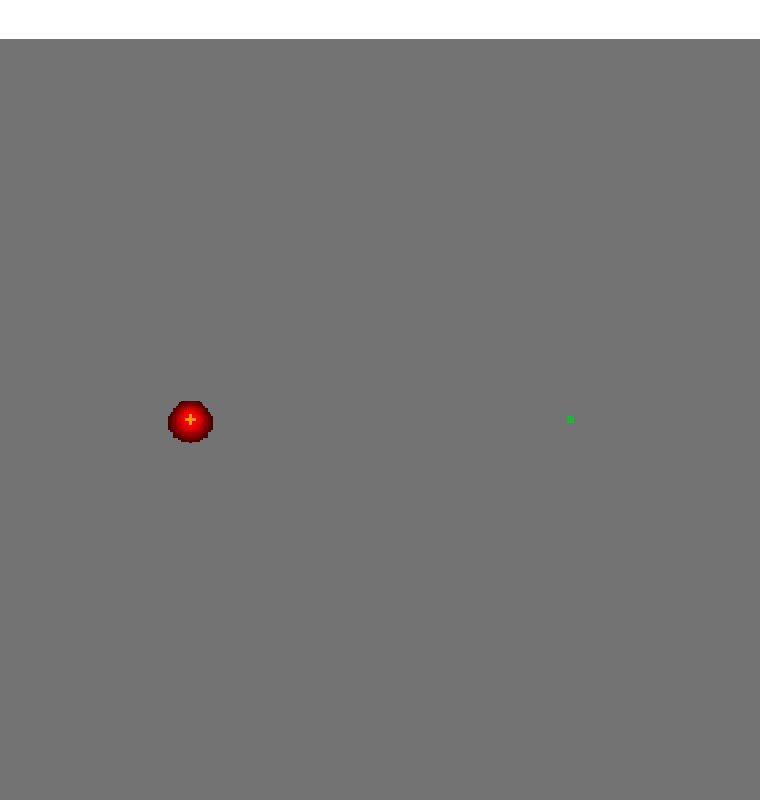

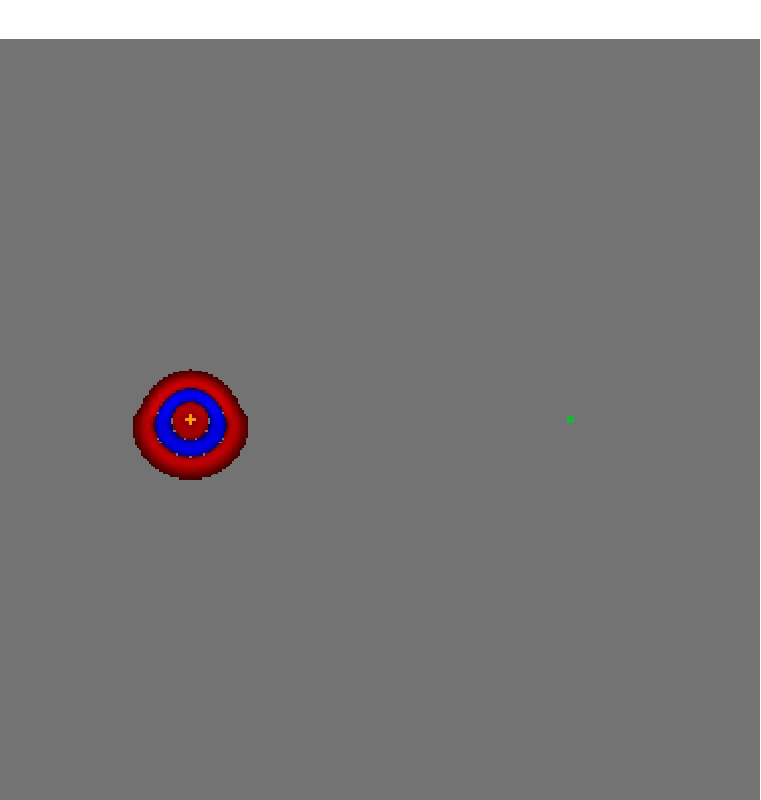

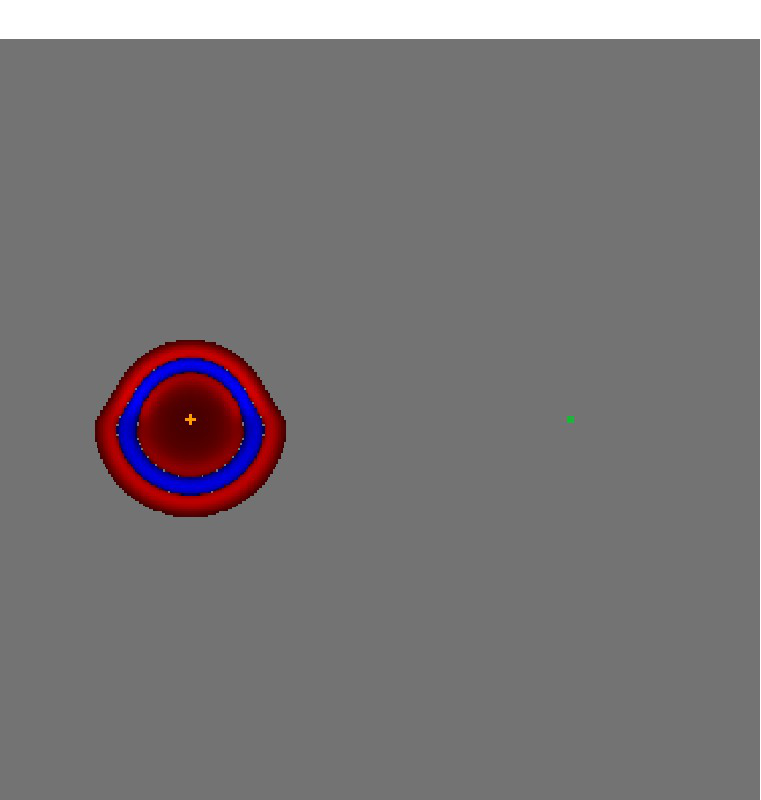

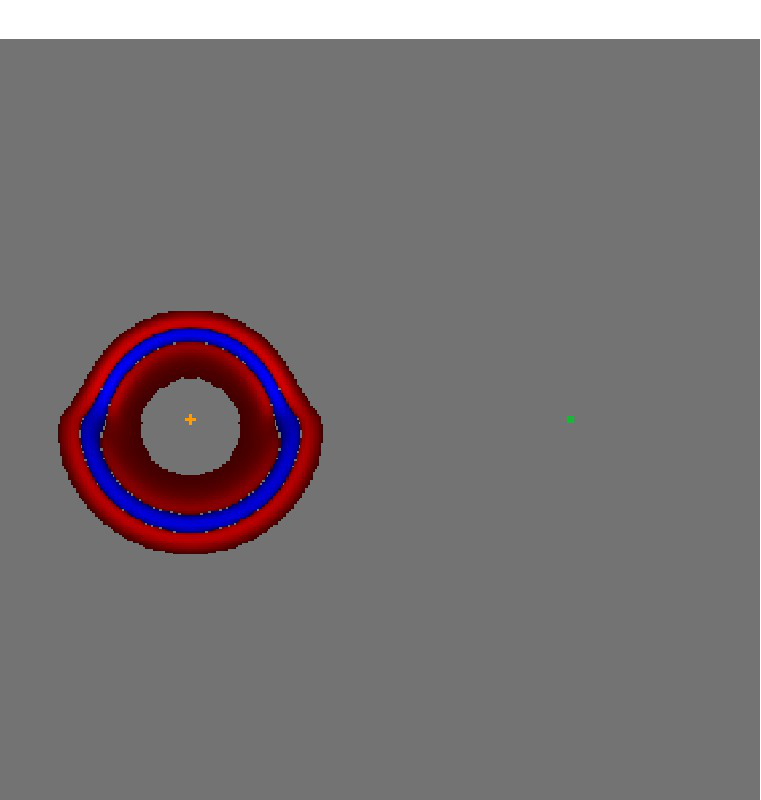

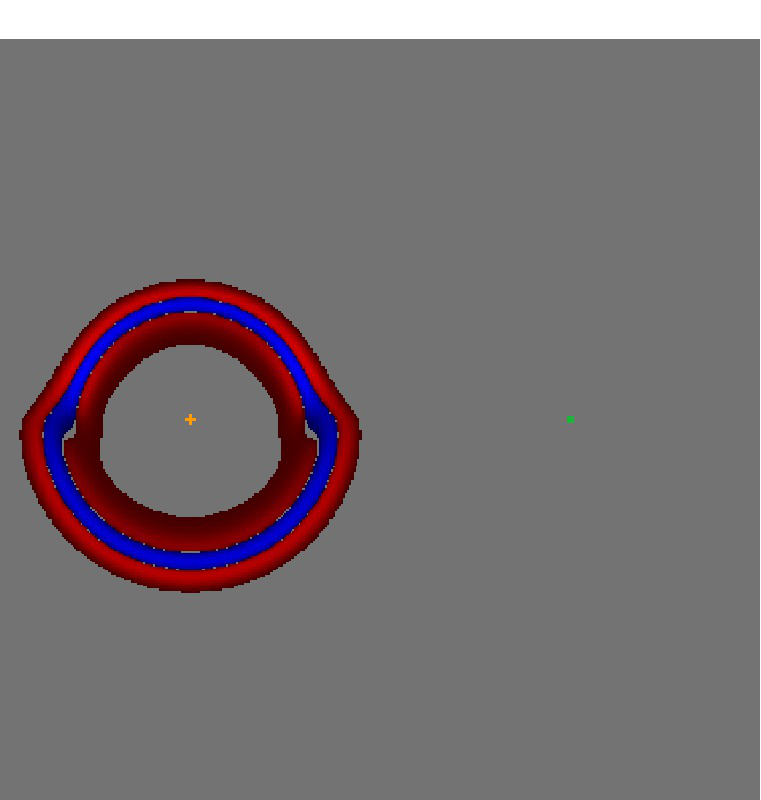

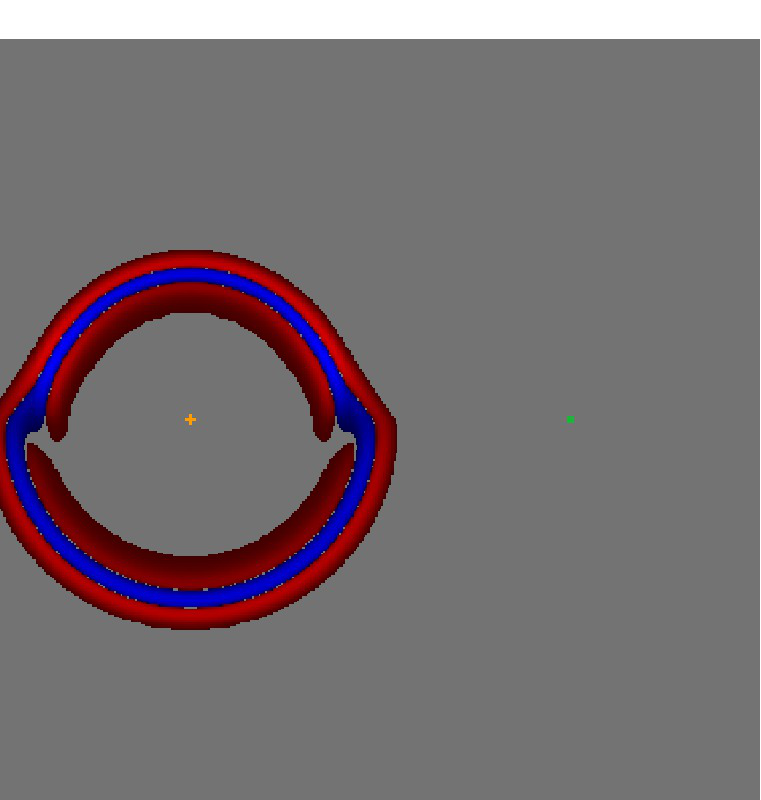

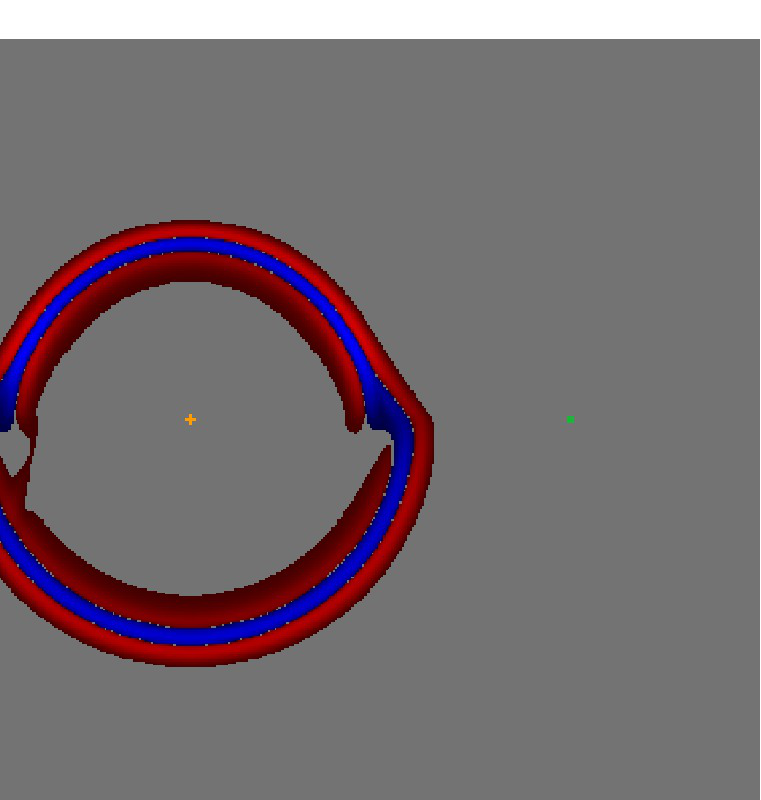

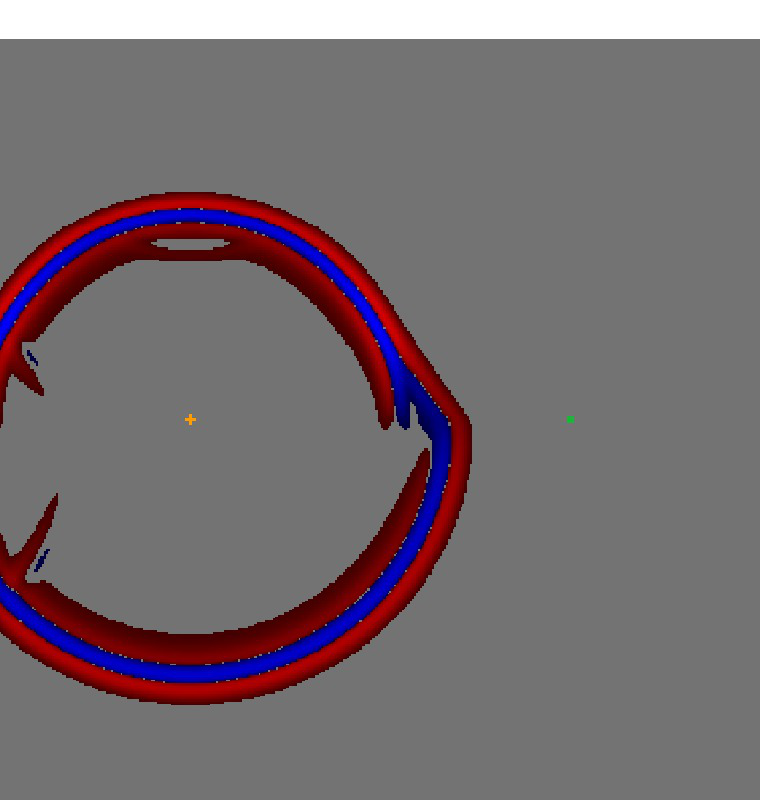

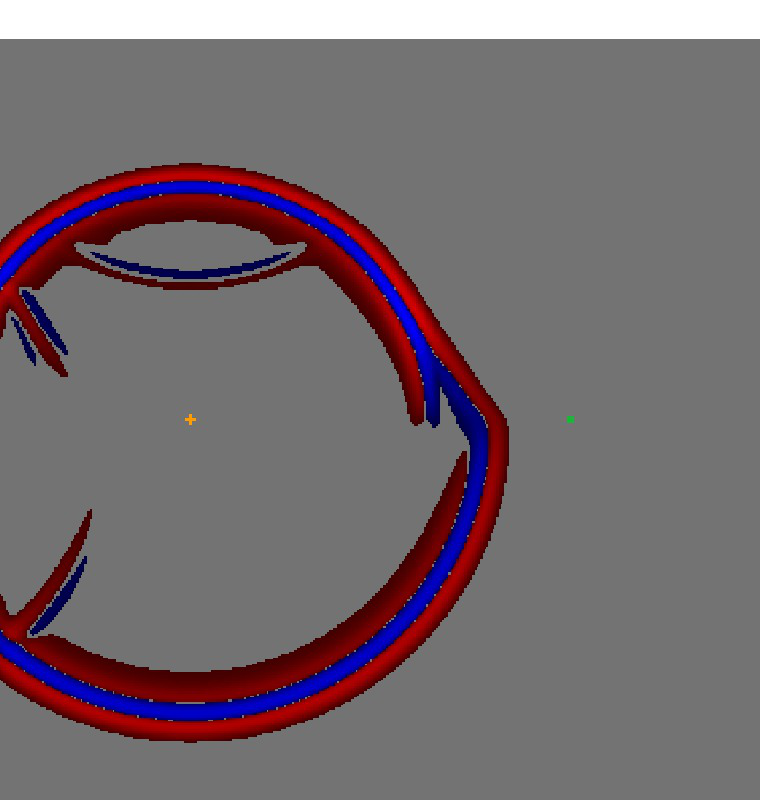

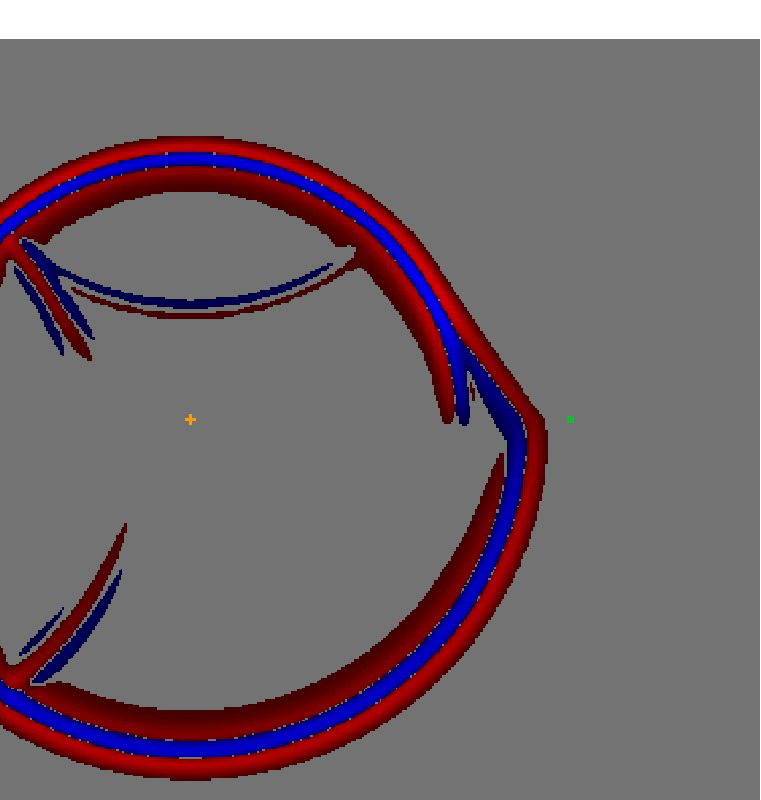

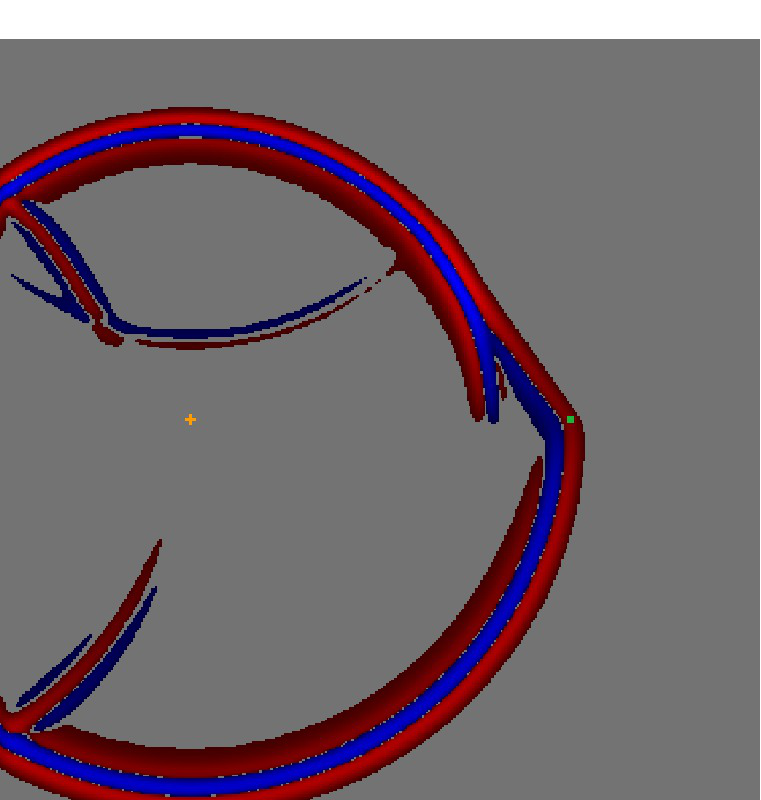

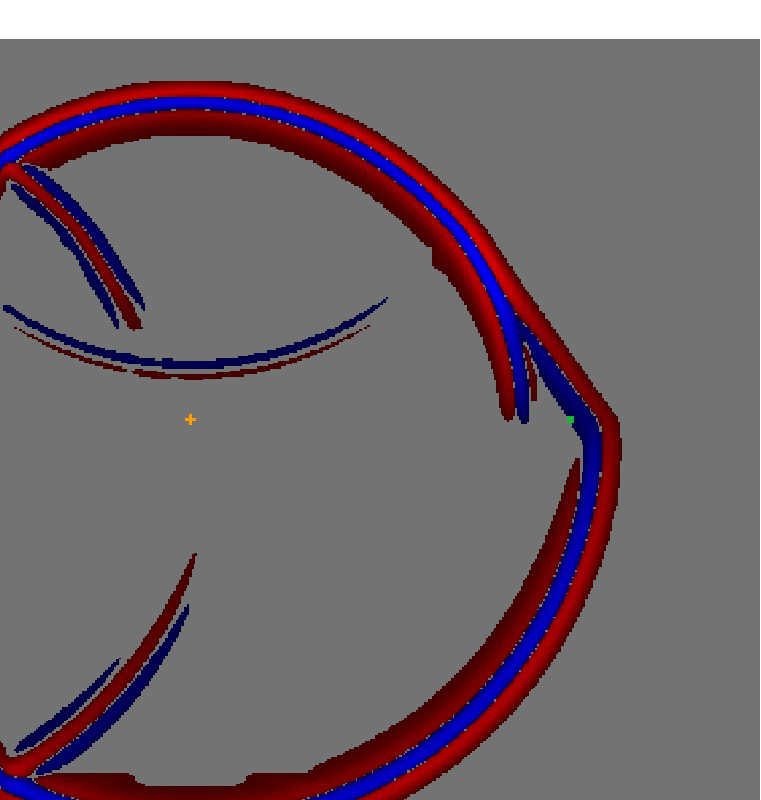

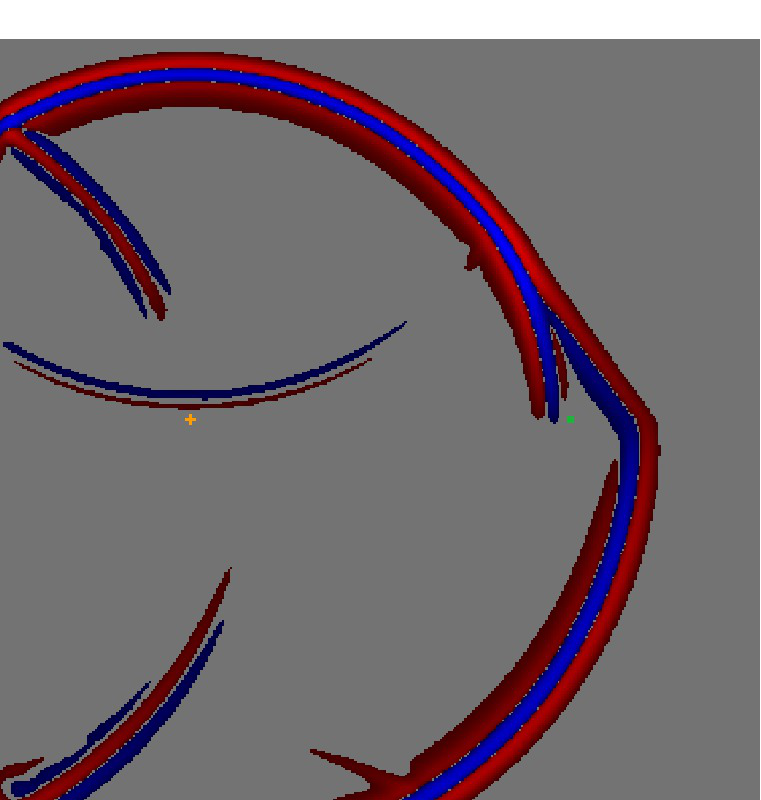

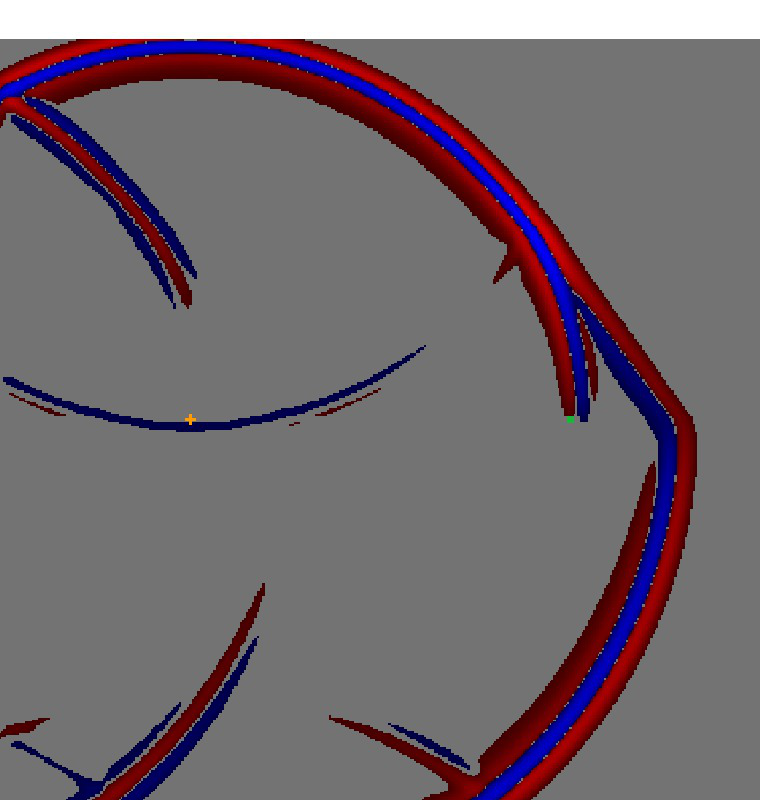

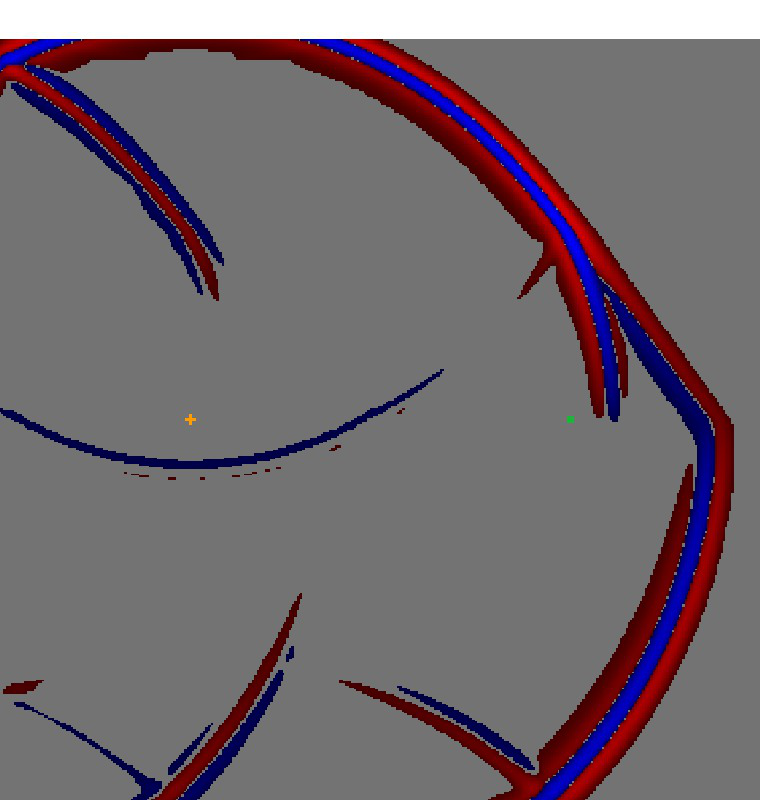

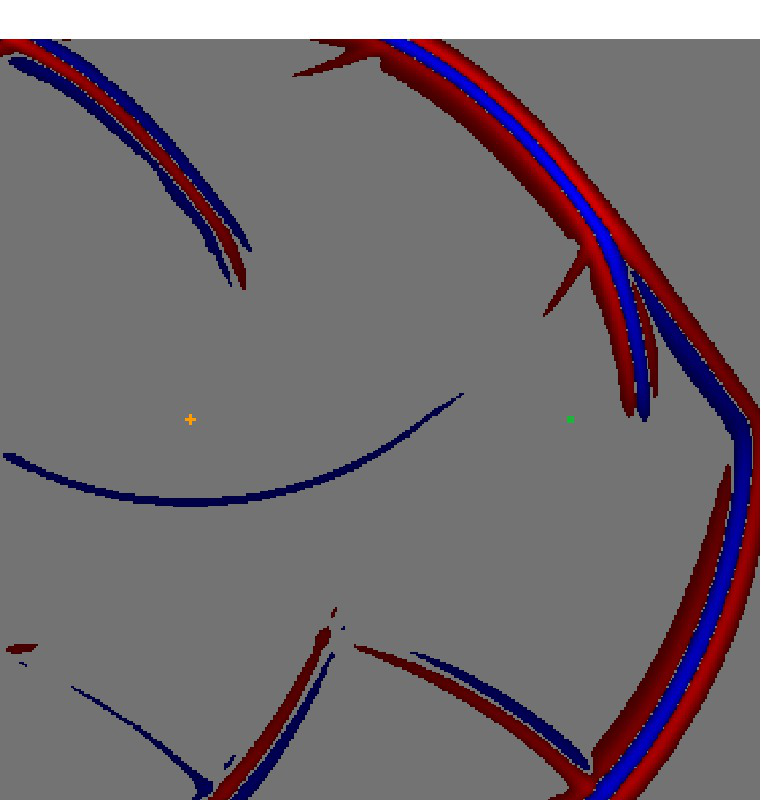

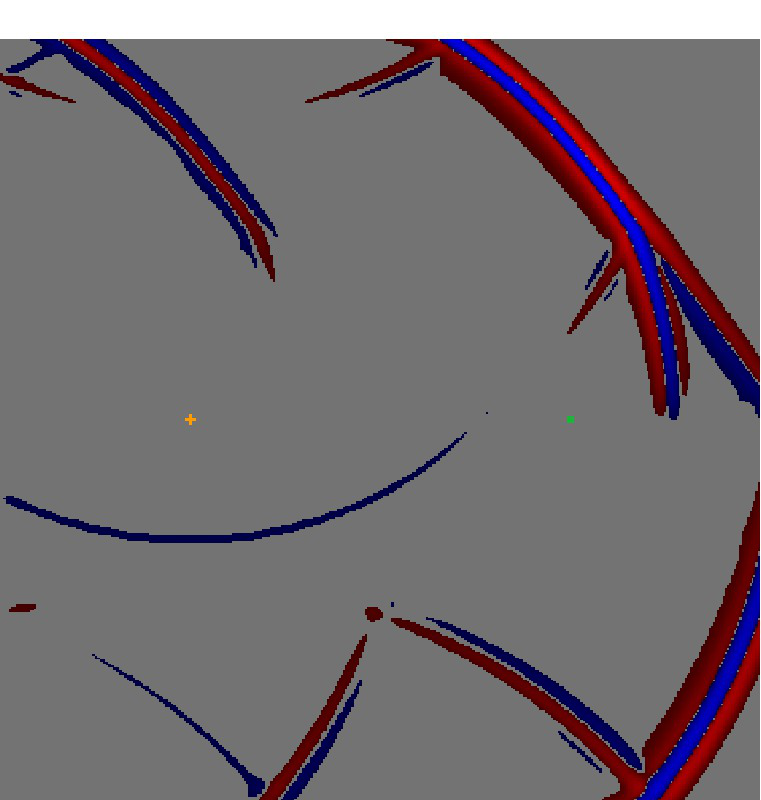

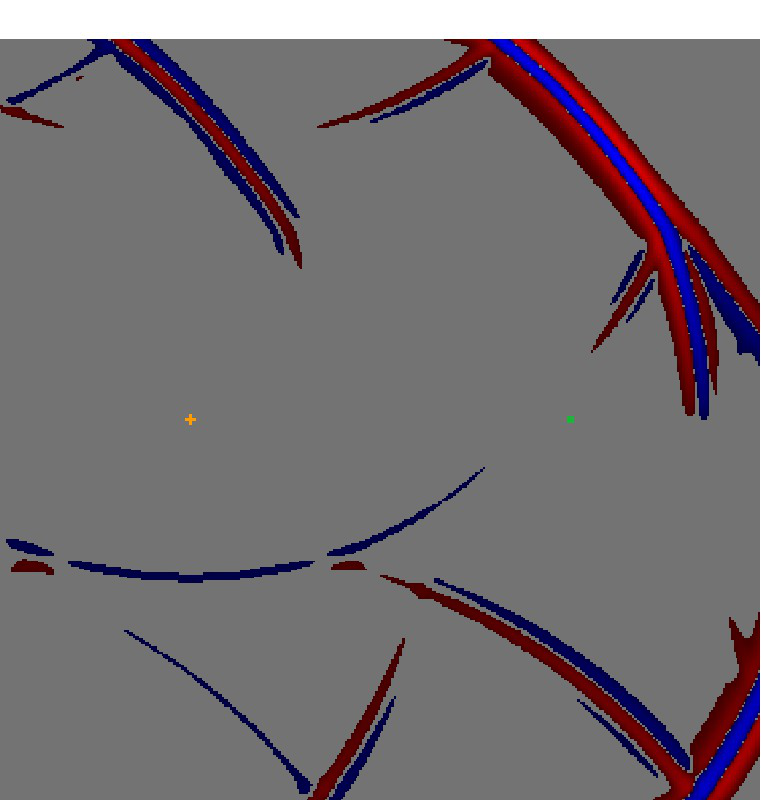

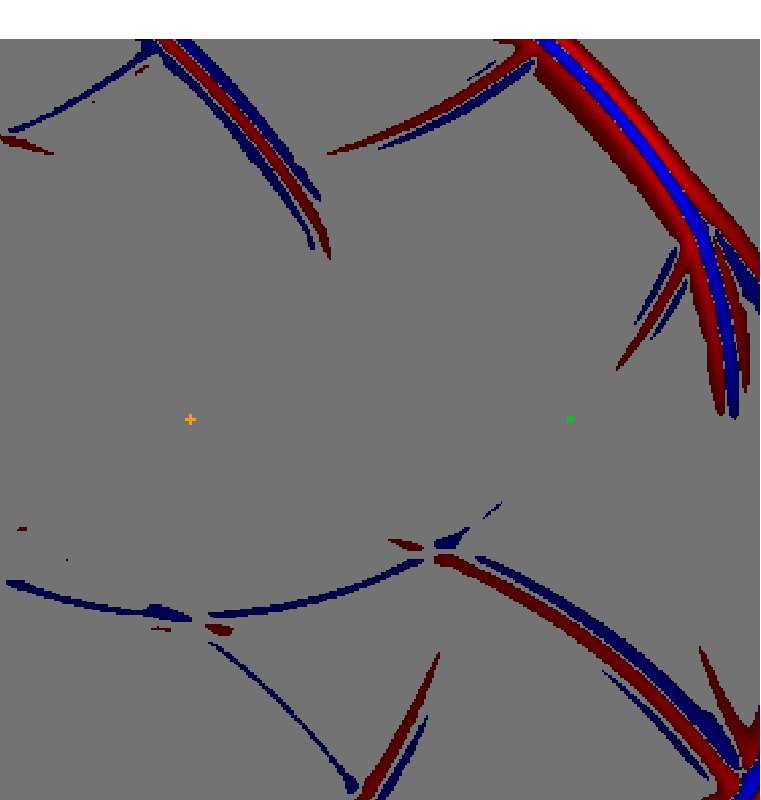

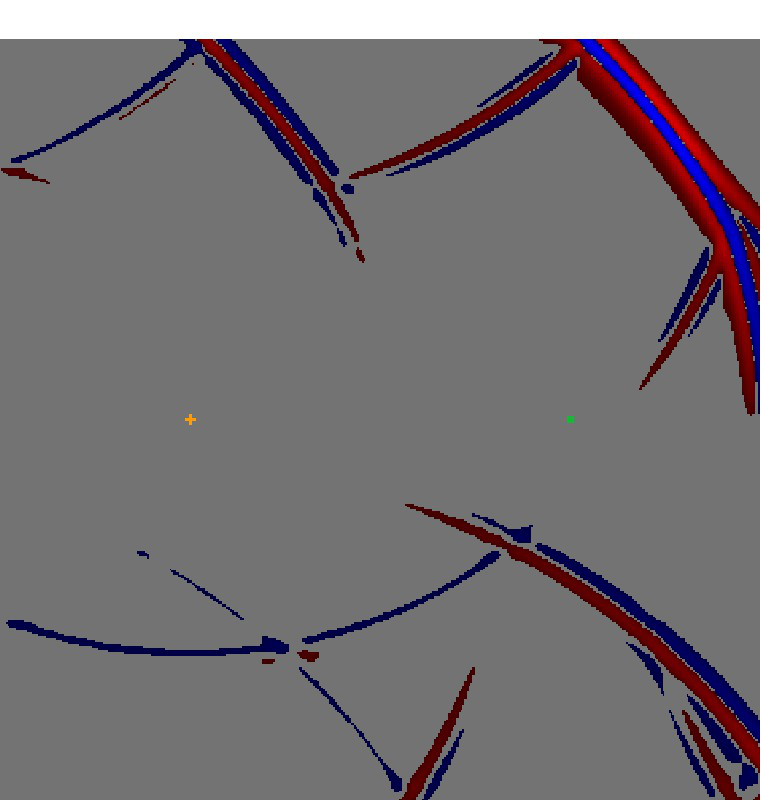

In [7]:
### 4. Snapshots 
os.chdir(SPECFEM2D_OUTPUT)
images=[]
# collect all .jpg files in OUTPUT_FILES directory
fs = !ls *.jpg
# Print .jpg files
for ea in fs:
    images.append(dp.Image(filename=ea,format='jpg'))
for ea in fs:
    dp.display(Image.open(ea))